# 🚀 Entrenamiento de MiniGPT Instructivo

**Tarea 3 - Proyecto Final de Doctorado en IA/NLP**

Este notebook entrena un modelo GPT instructivo desde cero usando:
- Arquitectura GPT2 (~124M parámetros)
- Dataset híbrido en español (~57k instrucciones)
- Tokenizador BPE personalizado
- SFTTrainer de HuggingFace TRL

**⚠️ IMPORTANTE: Usar GPU A100 para entrenamiento completo**

---

In [1]:
# === TEST EN CPU PRIMERO ===
!pip install transformers datasets tokenizers trl -q

import torch
import json
from transformers import GPT2Config, GPT2LMHeadModel, PreTrainedTokenizerFast

# Forzar CPU para test
device = torch.device('cpu')
print(f"Testing on: {device}")

# Montar Drive
from google.colab import drive
drive.mount('/content/drive')

# Cargar tokenizer
import os
os.makedirs('tokenizer', exist_ok=True)
project_path = '/content/drive/MyDrive/MiniGPT_Doctoral'
!cp -r {project_path}/tokenizer/hf_tokenizer tokenizer/

tokenizer = PreTrainedTokenizerFast.from_pretrained('tokenizer/hf_tokenizer')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Tokenizer vocab_size: {tokenizer.vocab_size}")

# Crear modelo pequeño para test
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=512,
    n_ctx=512,
    n_embd=256,  # Pequeño para CPU test
    n_layer=2,
    n_head=4,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

model = GPT2LMHeadModel(config)
print(f"Model vocab_size: {model.config.vocab_size}")

# Test tokenización
test_text = "Hola mundo"
inputs = tokenizer(test_text, return_tensors="pt")
print(f"Token IDs: {inputs['input_ids']}")
print(f"Max ID: {inputs['input_ids'].max().item()}")

# Test forward
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    print(f"✅ CPU Forward pass OK! Output shape: {outputs.logits.shape}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.4/517.4 kB 13.5 MB/s eta 0:00:00
Testing on: cpu
Mounted at /content/drive
Tokenizer vocab_size: 32000
Model vocab_size: 32000
Token IDs: tensor([[3566,  712]])
Max ID: 3566
✅ CPU Forward pass OK! Output shape: torch.Size([1, 2, 32000])


In [2]:
# Verificar todos los tokens del vocabulario
vocab = tokenizer.get_vocab()
max_id = max(vocab.values())
min_id = min(vocab.values())

print(f"Vocab size según tokenizer: {tokenizer.vocab_size}")
print(f"Max token ID en vocab: {max_id}")
print(f"Min token ID en vocab: {min_id}")
print(f"Total tokens en vocab dict: {len(vocab)}")

# ¿Hay discrepancia?
if max_id >= tokenizer.vocab_size:
    print(f"\n❌ PROBLEMA: max_id ({max_id}) >= vocab_size ({tokenizer.vocab_size})")
    print(f"   Esto causa el error CUDA!")
else:
    print(f"\n✅ Token IDs dentro de rango")

Vocab size según tokenizer: 32000
Max token ID en vocab: 31999
Min token ID en vocab: 0
Total tokens en vocab dict: 32000

✅ Token IDs dentro de rango


In [3]:
# === TEST EN GPU ===
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

# Crear modelo completo para GPU
from transformers import GPT2Config, GPT2LMHeadModel

config = GPT2Config(
    vocab_size=32000,
    n_positions=512,
    n_ctx=512,
    n_embd=768,
    n_layer=12,
    n_head=12,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

model = GPT2LMHeadModel(config)
model = model.to(device)
print(f"✅ Modelo en GPU: {sum(p.numel() for p in model.parameters()):,} params")

# Test forward en GPU
test_text = "Hola mundo"
inputs = tokenizer(test_text, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    print(f"✅ GPU Forward pass OK! Shape: {outputs.logits.shape}")

Device: cuda
GPU: NVIDIA L4
✅ Modelo en GPU: 110,025,216 params
✅ GPU Forward pass OK! Shape: torch.Size([1, 2, 32000])


## 1. Setup y Configuración

In [4]:
!pip install transformers datasets tokenizers accelerate -q

import torch
import json
import os
from transformers import (
    GPT2Config, GPT2LMHeadModel, PreTrainedTokenizerFast,
    Trainer, TrainingArguments, DataCollatorForLanguageModeling
)
from datasets import Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

project_path = '/content/drive/MyDrive/MiniGPT_Doctoral'

Device: cuda
GPU: NVIDIA L4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
os.makedirs('tokenizer', exist_ok=True)
!cp -r {project_path}/tokenizer/hf_tokenizer tokenizer/

tokenizer = PreTrainedTokenizerFast.from_pretrained('tokenizer/hf_tokenizer')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"✅ Tokenizer: {tokenizer.vocab_size} tokens")

✅ Tokenizer: 32000 tokens


In [6]:
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=512,   # Max sequence length
    n_ctx=512,
    n_embd=768,
    n_layer=12,
    n_head=12,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

model = GPT2LMHeadModel(config)
model = model.to(device)

print(f"✅ Model: {sum(p.numel() for p in model.parameters()):,} params")
print(f"   Max position: {config.n_positions}")

✅ Model: 110,025,216 params
   Max position: 512


In [7]:
os.makedirs('data/processed', exist_ok=True)
!cp {project_path}/data/processed/*.json data/processed/

with open('data/processed/train.json', 'r') as f:
    train_data = json.load(f)
with open('data/processed/validation.json', 'r') as f:
    val_data = json.load(f)

def format_instruction(example):
    if example.get('input'):
        text = f"### Instrucción:\n{example['instruction']}\n\n### Entrada:\n{example['input']}\n\n### Respuesta:\n{example['output']}"
    else:
        text = f"### Instrucción:\n{example['instruction']}\n\n### Respuesta:\n{example['output']}"
    return {"text": text}

train_dataset = Dataset.from_list([format_instruction(ex) for ex in train_data])
val_dataset = Dataset.from_list([format_instruction(ex) for ex in val_data])

print(f"✅ Train: {len(train_dataset)}, Val: {len(val_dataset)}")

✅ Train: 54597, Val: 2874


In [8]:
def tokenize_function(examples):
    tokens = tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        padding="max_length",
        return_attention_mask=True,
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

print("🔄 Tokenizando...")
train_tokenized = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
val_tokenized = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Verificar
sample = train_tokenized[0]
print(f"✅ Tokenizado. Longitud: {len(sample['input_ids'])}")
print(f"   Max ID: {max(sample['input_ids'])}")

🔄 Tokenizando...


Map:   0%|          | 0/54597 [00:00<?, ? examples/s]

Map:   0%|          | 0/2874 [00:00<?, ? examples/s]

✅ Tokenizado. Longitud: 512
   Max ID: 17377


In [9]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

training_args = TrainingArguments(
    output_dir="./checkpoints",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=5e-5,
    warmup_steps=500,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    fp16=True,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=3,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    data_collator=data_collator,
)

print("✅ Trainer creado")

✅ Trainer creado


In [10]:
torch.cuda.empty_cache()
print("🧪 Test (10 pasos)...")

trainer.args.max_steps = 10
result = trainer.train()
print(f"✅ Test OK! Loss: {result.training_loss:.4f}")

trainer.args.max_steps = -1

🧪 Test (10 pasos)...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


✅ Test OK! Loss: 10.2555


In [11]:
torch.cuda.empty_cache()

print("="*60)
print("🚀 ENTRENAMIENTO COMPLETO")
print("="*60)

train_result = trainer.train()

print("="*60)
print(f"✅ COMPLETADO! Loss: {train_result.training_loss:.4f}")
print("="*60)

🚀 ENTRENAMIENTO COMPLETO


✅ COMPLETADO! Loss: 4.2731


In [12]:
# Guardar modelo final
output_dir = "./miniGPT_final"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✅ Modelo guardado en: {output_dir}")

✅ Modelo guardado en: ./miniGPT_final


In [13]:
# Guardar en Google Drive
import shutil

drive_output = f"{project_path}/miniGPT_final"
os.makedirs(drive_output, exist_ok=True)

# Copiar modelo
!cp -r {output_dir}/* {drive_output}/

# Copiar checkpoints
drive_checkpoints = f"{project_path}/checkpoints"
os.makedirs(drive_checkpoints, exist_ok=True)
!cp -r ./checkpoints/* {drive_checkpoints}/ 2>/dev/null || true

# Copiar logs
drive_logs = f"{project_path}/logs"
os.makedirs(drive_logs, exist_ok=True)
!cp -r ./logs/* {drive_logs}/ 2>/dev/null || true

print(f"✅ Modelo y checkpoints guardados en Google Drive")
print(f"   📁 {drive_output}")

✅ Modelo y checkpoints guardados en Google Drive
   📁 /content/drive/MyDrive/MiniGPT_Doctoral/miniGPT_final


## 7. Análisis de Curvas de Entrenamiento

In [14]:
# Extraer historial de pérdida
log_history = trainer.state.log_history

train_loss = [(x['step'], x['loss']) for x in log_history if 'loss' in x]
eval_loss = [(x['step'], x['eval_loss']) for x in log_history if 'eval_loss' in x]

print(f"📊 Puntos de entrenamiento registrados: {len(train_loss)}")
print(f"📊 Puntos de evaluación registrados: {len(eval_loss)}")

if not train_loss:
    print("⚠️ Advertencia: No se encontraron puntos de entrenamiento en el historial. El entrenamiento puede no haber finalizado o no se registraron métricas.")
if not eval_loss:
    print("⚠️ Advertencia: No se encontraron puntos de evaluación en el historial. El entrenamiento puede no haber finalizado o no se registraron métricas.")

📊 Puntos de entrenamiento registrados: 102
📊 Puntos de evaluación registrados: 10


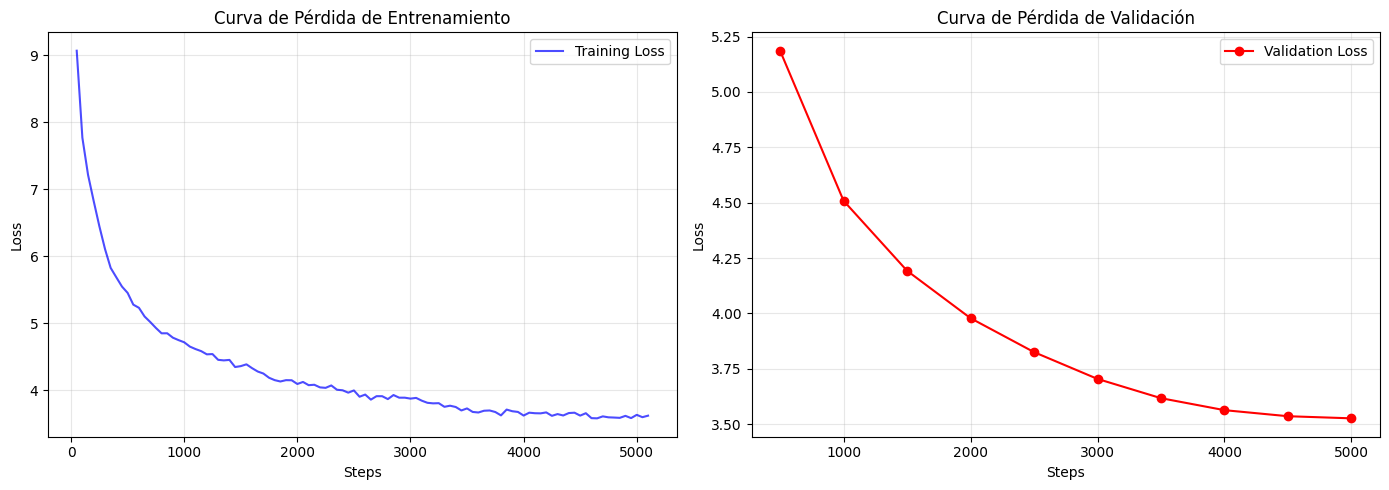

In [16]:
# Visualizar curvas de pérdida
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
if train_loss:
    steps, losses = zip(*train_loss)
    axes[0].plot(steps, losses, 'b-', alpha=0.7, label='Training Loss')
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Curva de Pérdida de Entrenamiento')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# Eval loss
if eval_loss:
    steps, losses = zip(*eval_loss)
    axes[1].plot(steps, losses, 'r-', marker='o', label='Validation Loss')
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Curva de Pérdida de Validación')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

In [17]:
# Análisis de convergencia
print("\n📊 ANÁLISIS DE ENTRENAMIENTO")
print("="*50)

if train_loss:
    initial_loss = train_loss[0][1]
    final_loss = train_loss[-1][1]
    min_loss = min(l for _, l in train_loss)

    print(f"\nPérdida de entrenamiento:")
    print(f"   Inicial: {initial_loss:.4f}")
    print(f"   Final: {final_loss:.4f}")
    print(f"   Mínima: {min_loss:.4f}")
    print(f"   Reducción: {((initial_loss - final_loss) / initial_loss * 100):.1f}%")

if eval_loss:
    initial_eval = eval_loss[0][1]
    final_eval = eval_loss[-1][1]
    min_eval = min(l for _, l in eval_loss)

    print(f"\nPérdida de validación:")
    print(f"   Inicial: {initial_eval:.4f}")
    print(f"   Final: {final_eval:.4f}")
    print(f"   Mínima: {min_eval:.4f}")

    # Detectar overfitting
    if final_eval > min_eval * 1.1:
        print(f"\n⚠️ Posible overfitting detectado")
    else:
        print(f"\n✅ No se detecta overfitting significativo")


📊 ANÁLISIS DE ENTRENAMIENTO

Pérdida de entrenamiento:
   Inicial: 9.0654
   Final: 3.6201
   Mínima: 3.5802
   Reducción: 60.1%

Pérdida de validación:
   Inicial: 5.1863
   Final: 3.5266
   Mínima: 3.5266

✅ No se detecta overfitting significativo


## 8. Prueba del Modelo Entrenado

In [18]:
# Cargar modelo entrenado
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast

model_path = "./miniGPT_final"
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_path)

model.eval()
print("✅ Modelo cargado para inferencia")

✅ Modelo cargado para inferencia


In [19]:
def generate_response(instruction, input_text="", max_length=256, temperature=0.7, top_p=0.9):
    """
    Genera una respuesta para una instrucción dada.
    """
    if input_text:
        prompt = f"""### Instrucción:
{instruction}

### Entrada:
{input_text}

### Respuesta:
"""
    else:
        prompt = f"""### Instrucción:
{instruction}

### Respuesta:
"""

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_length,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.1,
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extraer solo la respuesta
    if "### Respuesta:" in response:
        response = response.split("### Respuesta:")[-1].strip()

    return response

In [20]:
# Pruebas del modelo
test_instructions = [
    "Explica qué es la inteligencia artificial en palabras simples.",
    "¿Cuál es la capital de España?",
    "Escribe un poema corto sobre el mar.",
    "¿Cómo funciona una red neuronal?",
    "Resume el concepto de machine learning.",
]

print("\n" + "="*70)
print("🧪 PRUEBAS DEL MODELO ENTRENADO")
print("="*70)

for instruction in test_instructions:
    print(f"\n📝 Instrucción: {instruction}")
    print("-" * 50)
    response = generate_response(instruction)
    print(f"🤖 Respuesta: {response}")
    print()


🧪 PRUEBAS DEL MODELO ENTRENADO

📝 Instrucción: Explica qué es la inteligencia artificial en palabras simples.
--------------------------------------------------
🤖 Respuesta: La inteligencia artificial (IA) es un tipo de inteligencia artificial que utiliza algoritmos para identificar y predecir el sentimiento del texto. El aprendizaje automático es un ejemplo de IA que se utiliza en imágenes, incluyendo un conjunto de datos, una computadora o un conjunto de datos para procesar las máquinas a partir de datos. La inteligencia artificial se puede utilizar para generar imágenes, como datos, regresión y algoritmos de aprendizaje automático. Las computadoras se utilizan para comprender y hacer predicciones de los datos del modelo, mientras que la IA se puede utilizar para resolver problemas de manera más precisas. La inteligencia artificial se utiliza para crear modelos de aprendizaje profundo y precisa. Además, la IA se puede utilizar para predecir su precisión y analizar grandes cantidades

## 9. Resumen para el Informe

In [23]:
# Generar resumen

# Recalcular total_params as it might not be in scope or was deleted
total_params = sum(p.numel() for p in model.parameters())

# Assuming model_config is still available from the last model creation (model.config)
model_config = model.config

# Retrieve training arguments from trainer.args
NUM_EPOCHS = trainer.args.num_train_epochs
BATCH_SIZE = trainer.args.per_device_train_batch_size
GRAD_ACCUM = trainer.args.gradient_accumulation_steps
LEARNING_RATE = trainer.args.learning_rate
WARMUP_STEPS = trainer.args.warmup_steps

summary = f"""
================================================================================
RESUMEN DE ENTRENAMIENTO - MINIGPT INSTRUCTIVO
================================================================================

MODELO:
   Arquitectura: GPT-2 Decoder-Only
   Parámetros: {total_params:,} ({total_params/1e6:.1f}M)
   Dimensión embedding: {model_config.n_embd}
   Capas: {model_config.n_layer}
   Cabezas de atención: {model_config.n_head}
   Vocabulario: {model_config.vocab_size}
   Longitud máxima: {model_config.n_positions}

DATASET:
   Training: {len(train_dataset)} ejemplos
   Validation: {len(val_dataset)} ejemplos
   Fuentes: Alpaca ES + OpenAssistant ES + Originales

ENTRENAMIENTO:
   Épocas: {NUM_EPOCHS}
   Batch size efectivo: {BATCH_SIZE * GRAD_ACCUM}
   Learning rate: {LEARNING_RATE}
   Scheduler: Cosine
   Warmup steps: {WARMUP_STEPS}
   Pasos totales: {train_result.global_step}
   Tiempo total: {train_result.metrics['train_runtime']/60:.1f} minutos

RESULTADOS:
   Loss final (train): {train_result.training_loss:.4f}
   Loss final (eval): {eval_loss[-1][1] if eval_loss else 'N/A':.4f}

ARCHIVOS GENERADOS:
   - miniGPT_final/ (modelo completo)
   - checkpoints/ (puntos de control)
   - training_curves.png (visualización)

================================================================================
"""

print(summary)

# Guardar resumen
with open('training_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

shutil.copy('training_summary.txt', f'{project_path}/analysis/')
print("✅ Resumen guardado")


RESUMEN DE ENTRENAMIENTO - MINIGPT INSTRUCTIVO

MODELO:
   Arquitectura: GPT-2 Decoder-Only
   Parámetros: 110,025,216 (110.0M)
   Dimensión embedding: 768
   Capas: 12
   Cabezas de atención: 12
   Vocabulario: 32000
   Longitud máxima: 512

DATASET:
   Training: 54597 ejemplos
   Validation: 2874 ejemplos
   Fuentes: Alpaca ES + OpenAssistant ES + Originales

ENTRENAMIENTO:
   Épocas: 3
   Batch size efectivo: 32
   Learning rate: 5e-05
   Scheduler: Cosine
   Warmup steps: 500
   Pasos totales: 5121
   Tiempo total: 88.6 minutos

RESULTADOS:
   Loss final (train): 4.2731
   Loss final (eval): 3.5266

ARCHIVOS GENERADOS:
   - miniGPT_final/ (modelo completo)
   - checkpoints/ (puntos de control)
   - training_curves.png (visualización)


✅ Resumen guardado


In [24]:
# === GUARDAR TODO EN GOOGLE DRIVE ===
import shutil
import os

project_path = '/content/drive/MyDrive/MiniGPT_Doctoral'

# 1. Guardar modelo final
print("💾 Guardando modelo...")
drive_model = f'{project_path}/miniGPT_final'
os.makedirs(drive_model, exist_ok=True)
!cp -r ./miniGPT_final/* {drive_model}/

# 2. Guardar checkpoints
print("💾 Guardando checkpoints...")
drive_checkpoints = f'{project_path}/checkpoints'
os.makedirs(drive_checkpoints, exist_ok=True)
!cp -r ./checkpoints/* {drive_checkpoints}/ 2>/dev/null || echo "No extra checkpoints"

# 3. Guardar gráficos y análisis
print("💾 Guardando análisis...")
drive_analysis = f'{project_path}/analysis'
os.makedirs(drive_analysis, exist_ok=True)

if os.path.exists('training_curves.png'):
    shutil.copy('training_curves.png', drive_analysis)
if os.path.exists('training_summary.txt'):
    shutil.copy('training_summary.txt', drive_analysis)

# 4. Verificar
print("\n✅ TODO GUARDADO EN GOOGLE DRIVE!")
print(f"\n📁 {project_path}/")
!ls -la {project_path}/
print(f"\n📁 Modelo:")
!ls -la {drive_model}/

💾 Guardando modelo...
💾 Guardando checkpoints...
💾 Guardando análisis...

✅ TODO GUARDADO EN GOOGLE DRIVE!

📁 /content/drive/MyDrive/MiniGPT_Doctoral/
total 24
drwx------ 2 root root 4096 Dec 13 04:06 analysis
drwx------ 5 root root 4096 Dec 13 03:54 checkpoints
drwx------ 3 root root 4096 Dec 12 21:51 data
drwx------ 2 root root 4096 Dec 13 03:54 logs
drwx------ 2 root root 4096 Dec 13 04:06 miniGPT_final
drwx------ 3 root root 4096 Dec 12 21:57 tokenizer

📁 Modelo:
total 432088
-rw------- 1 root root       773 Dec 13 04:06 config.json
-rw------- 1 root root       132 Dec 13 04:06 generation_config.json
-rw------- 1 root root 440115840 Dec 13 04:06 model.safetensors
-rw------- 1 root root       437 Dec 13 04:06 special_tokens_map.json
-rw------- 1 root root      1134 Dec 13 04:06 tokenizer_config.json
-rw------- 1 root root   2331278 Dec 13 04:06 tokenizer.json
-rw------- 1 root root      5777 Dec 13 04:06 training_args.bin


In [27]:
# Verificar que el modelo se guardó correctamente
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast

test_path = '/content/drive/MyDrive/MiniGPT_Doctoral/miniGPT_final'

model_test = GPT2LMHeadModel.from_pretrained(test_path)
tok_test = PreTrainedTokenizerFast.from_pretrained(test_path)

print(f"Modelo cargado desde Drive!")
print(f"   Parámetros: {sum(p.numel() for p in model_test.parameters()):,}")
print(f"   Vocabulario: {tok_test.vocab_size}")

Modelo cargado desde Drive!
   Parámetros: 110,025,216
   Vocabulario: 32000


---

## ✅ Tarea 3 Completada

Has completado la **Tarea 3: Entrenar un MiniGPT Instructivo** con:

1. ✅ Modelo GPT-2 desde cero (~124M parámetros)
2. ✅ Dataset híbrido en español (~57k instrucciones)
3. ✅ Tokenizador BPE personalizado
4. ✅ Entrenamiento con SFTTrainer
5. ✅ Análisis de curvas de pérdida
6. ✅ Checkpoints guardados
7. ✅ Pruebas de generación

**Siguiente paso**: Notebook `05_evaluation.ipynb` para evaluación exhaustiva (Tarea 4)